### Dataset name is "California Housing Prices" 
##### (https://www.kaggle.com/datasets/camnugent/california-housing-prices)
##### Model 1 using polynomial regression. Cleaning and visualization steps are the same as in Model_2 linear regression model file. Go straight to the polynomial regression model implementation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
 # load data 
df = pd.read_csv("housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Cleaning up the dataset: ###

In [4]:
# Here I will train first model, so I will drop the latitude and longitude columns,
# I will work this them in the second model:
df = df.drop(["latitude","longitude"], axis=1)

##### First we will check if there are dublicates, missing values and how many options has "ocean_proximity" column.

In [5]:
# checking basic characteristics:
# total_bedroom column has less rows than other columns. We will check corelation with this column and
# after will decide what to do with it.
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# checking missing values
# only total beds column has missing value. Compare to total amount of rows, this is not a significant number.
df.isna().sum()

housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
# let's drop all missing values for total_beds column:
df = df.dropna(axis=0)

In [8]:
# no missing values anymore:
df.isna().sum()

housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [9]:
# there is no dublicates:
int(df.duplicated().sum())

0

##### "median_income" represents income in tens of thousands (A value of 8.3252 actually represents $83,252 (not $8.33)). I tried to convert it to whole numbers by multiplying 'median_income' * 10000, but model prediction gave negative "median_house_value", so I gave up on changing value to whole numbers.

In [10]:
# let's check "ocean_proximity" column:
# how many different values it has:

df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [11]:
# this column has 5 different values and we cannot drop it because distance to ocean should affet the house price.
# We will use OneHotEncoder and will create multiple columns with numeric values:
from sklearn.preprocessing import OneHotEncoder
variables = ["ocean_proximity"]
             
# use encoder:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [12]:
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


In [13]:
# next we will remove one new boolean variable (since it's going to be represented
# by a straight line of zeroes). There is just 5 values of "Island" ocean_proximity, let's drop this column:
df = df.drop("ocean_proximity_ISLAND", axis=1)

In [14]:
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,1,0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,1,0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,1,0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,1,0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,1,0


### Visualising the Data.
#### Now we will check the correlation between the features against each other and check distribution:

<Axes: xlabel='median_house_value', ylabel='Count'>

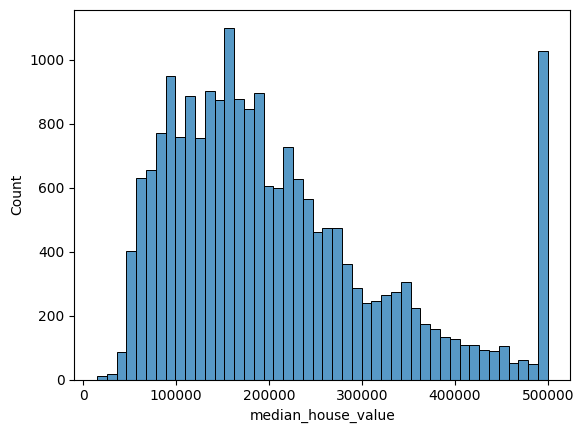

In [15]:
# checking target variable distribution:
# there is a lot of houses more than 500000 and this destroy data distribution very much
# we will need to cut tail on a right side to get closer to normal distribution:
sns.histplot(df['median_house_value'])

In [16]:
# we will use quantiles to remove the top % in order to get closer to normal distribution
df = df.query("median_house_value < median_house_value.quantile(0.93)")

<Axes: xlabel='median_house_value', ylabel='Count'>

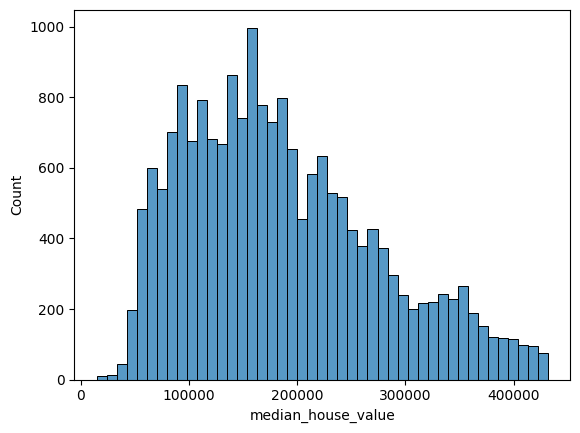

In [17]:
# now it looks better:
sns.histplot(df['median_house_value'])

In [18]:
# After removing extreme values, the dataset's row count dropped from 20,640 to 18,809:
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000,18999.000000
mean,28.267751,2612.246118,539.696195,1445.628507,501.015474,3.623434,185698.231275,0.434654,0.339123,0.104005,0.122059
std,12.479386,2183.468239,423.665099,1148.847565,384.173219,1.512881,88948.789128,0.495725,0.473424,0.305276,0.327363
min,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,1436.000000,297.000000,799.000000,282.000000,2.510400,114900.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,2103.000000,436.000000,1183.000000,410.000000,3.407100,170700.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,3110.000000,647.000000,1749.500000,604.000000,4.526150,241000.000000,1.000000,1.000000,0.000000,0.000000
max,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,431600.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

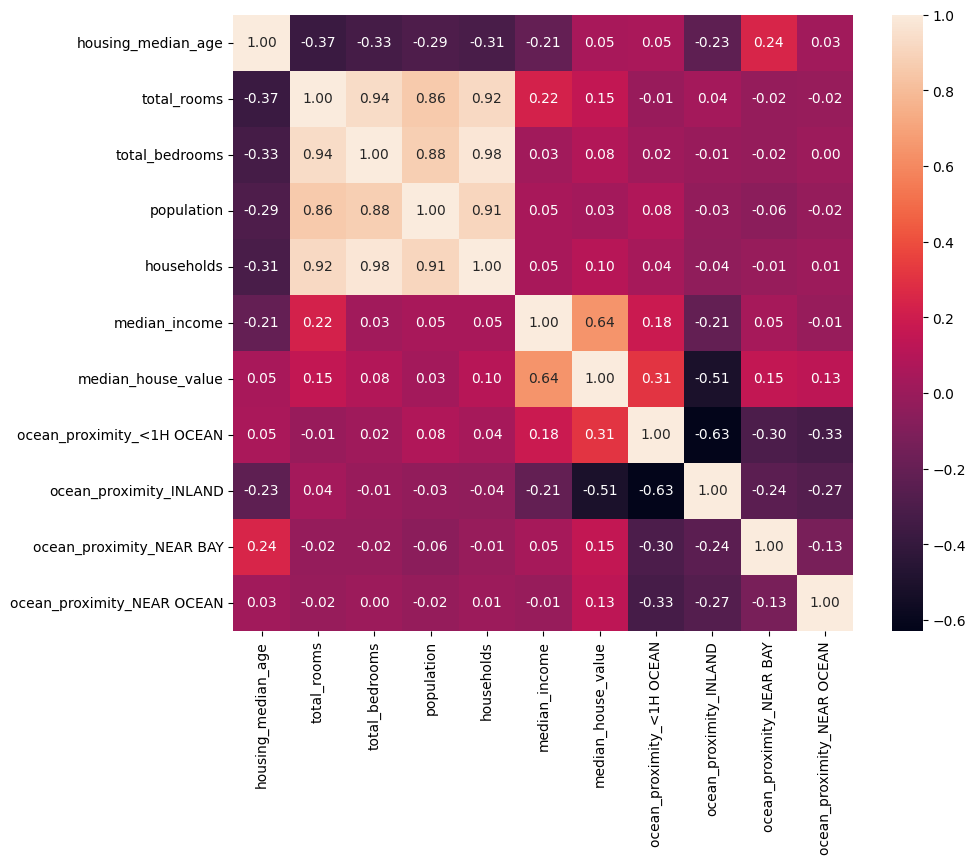

In [19]:
# it was difficult to see numbers, so we will increase the figure size:
plt.figure(figsize=(10, 8))

# on this correlation matrix we can see the most important supported variables:
# median_income. Also, "ocean_proximity_<1H OCEAN" variale correlate with out target variable and
# "ocean_proximity_INLAND" has negative correlation. 
correlations = df.corr(numeric_only=True)
sns.heatmap(correlations, annot=True, fmt='.2f')

<Axes: xlabel='median_income', ylabel='Count'>

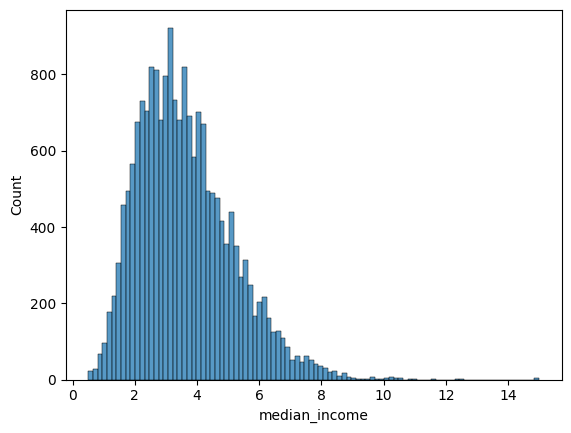

In [20]:
# Correlations between "median_house_value" and support variables: "total_rooms", "total_bedrooms","population" and "housing_median_age" are very weak.
# However,I will still check value distribution for "total_rooms", "total_bedrooms" variable as they have the highest correlation among the meanshioned above. 
# Because if there are many outliers, they will create addition noise in our model.
# First we will check "median_income" distributuion, since this variable has highest correlation among all the variables.
sns.histplot(df['median_income'])

In [21]:
# use quantiles to remove the top % in order to remove outliners:
df = df.query("median_income < median_income.quantile(0.99)")

<Axes: xlabel='median_income', ylabel='Count'>

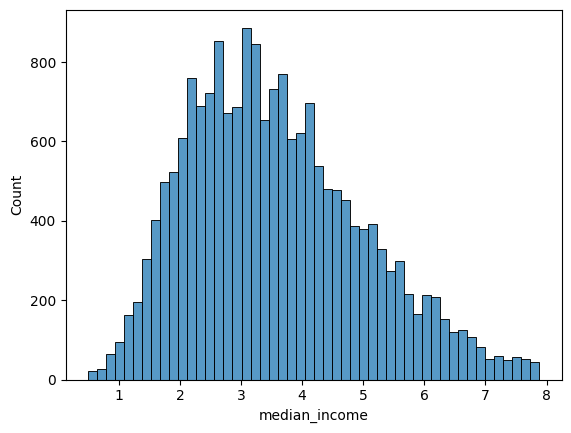

In [22]:
# now it looks like this:
sns.histplot(df['median_income'])

<Axes: xlabel='total_rooms', ylabel='Count'>

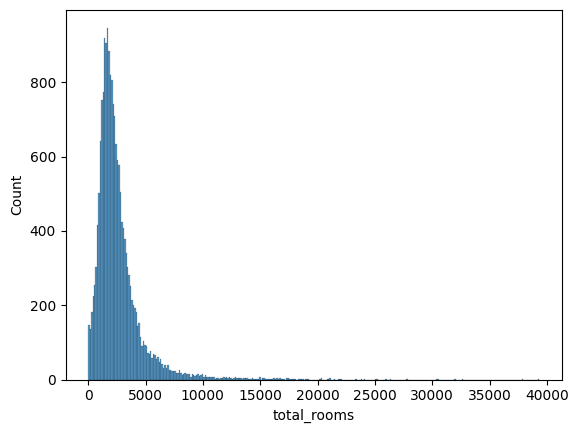

In [23]:
# checking distribution of "total_rooms"variable:
# here is a very long tail:
sns.histplot(df['total_rooms'])

In [24]:
# let's cut this tail:
df = df.query("total_rooms < total_rooms.quantile(0.97)")

<Axes: xlabel='total_rooms', ylabel='Count'>

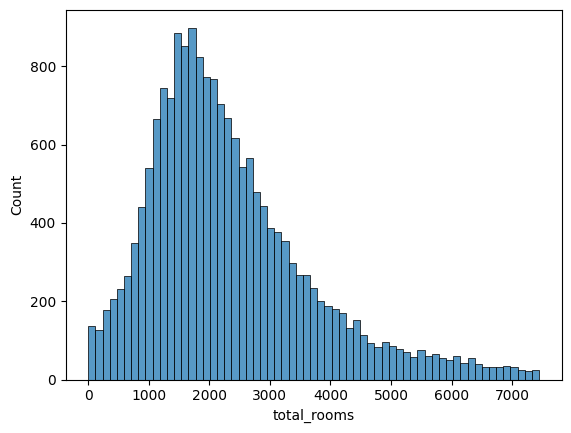

In [25]:
sns.histplot(df['total_rooms'])

<Axes: xlabel='total_bedrooms', ylabel='Count'>

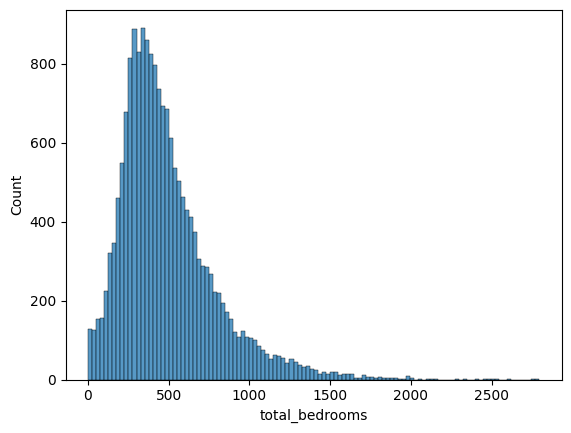

In [26]:
# checking distribution of "total_rooms"variable:
# this variable has not that long tail but still, we can cut a bit from the right side:
sns.histplot(df['total_bedrooms'])

In [27]:
# use quantiles to remove the top % in order to remove outliners:
df = df.query("total_bedrooms < total_bedrooms.quantile(0.98)")

<Axes: xlabel='total_bedrooms', ylabel='Count'>

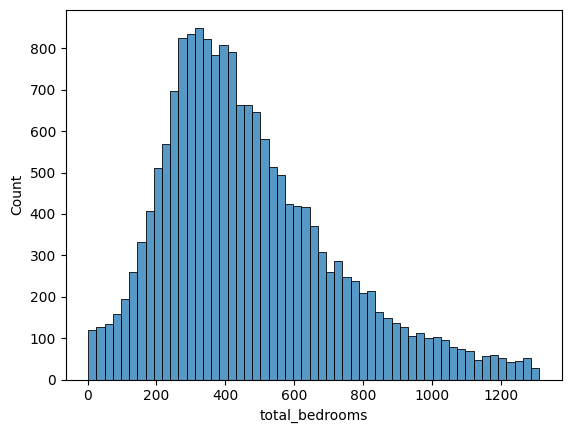

In [28]:
# checking distribution of "total_rooms"variable:
sns.histplot(df['total_bedrooms'])

In [29]:
# So, after this cutting we have fewer rows: from 18999 -> 17879 rows.
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000
mean,29.004419,2262.543207,470.680799,1283.719224,440.067174,3.552390,182881.419319,0.432854,0.337882,0.104536,0.124560
std,12.267511,1254.595760,251.947257,731.908489,233.987980,1.419586,87606.683877,0.495485,0.473001,0.305963,0.330228
min,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1400.500000,291.000000,782.000000,276.000000,2.481250,112900.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,2024.000000,422.000000,1148.000000,397.000000,3.375000,168200.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,2892.500000,607.000000,1643.000000,567.000000,4.453750,237500.000000,1.000000,1.000000,0.000000,0.000000
max,52.000000,7436.000000,1311.000000,8733.000000,1295.000000,7.877400,431600.000000,1.000000,1.000000,1.000000,1.000000


### Here we will try polynomial regression model. I will start with defining X and y -variables

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
# ref: https://www.javatpoint.com/machine-learning-polynomial-regression
# ref: ChatGPT

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# X -> use everything else except the target
X = df.drop("median_house_value", axis=1)

# Our target variable is y
y = df['median_house_value']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)  # Transform training data
X_test_poly = poly.transform(X_test)  # Transform test data (no fit to avoid data leakage)

# Train the model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predictions on the test set
y_pred = model.predict(X_test_poly)

# Evaluate performance on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Polynomial Regression (Degree 2) - MSE: {mse:.2f}, R² Score: {r2:.4f}")


Polynomial Regression (Degree 2) - MSE: 2607765433.17, R² Score: 0.6583


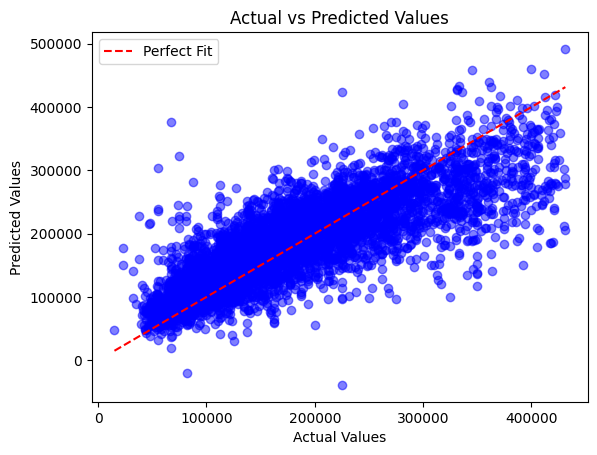

In [36]:
# visualization of the model:
plt.scatter(y_test, y_pred, color="blue", alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [38]:
df.columns


Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income', 'median_house_value',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [40]:
df.head(1)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,1,0


In [ ]:
# Flatten the dictionary into a single-row DataFrame
tester_row = pd.DataFrame([{
    "housing_median_age": 50,
    "total_rooms": 500,
    "total_bedrooms": 70,
    "population": 300,
    "households": 50,	
    "median_income": 8.4567, 
    "ocean_proximity_<1H OCEAN": 1,
    "ocean_proximity_INLAND": 0,
    "ocean_proximity_NEAR BAY": 0,
    "ocean_proximity_NEAR OCEAN": 0
}])

# Apply the same polynomial transformation
tester_row_poly = poly.transform(tester_row)

# Make the prediction
result = model.predict(tester_row_poly)[0]

# Print the result
print(f"Predicted house price with given parameters: {round(float(result), 2)} $")


Predicted house price with given parameters: 411317.34 $


### Results:
### Model 1 (using "ocean_proximity" column):
### - Linear Regression Model — R² Score: 0.6, predicted house price with given parameters: 400168.97 $
### - Polynomial Regression Model — R² Score: 0.66, predicted house price with given parameters:  411317.34 $
### We can conclude that Polynomial Regression Model has better prediction as it has higher R² Score.